In [1]:
import torch
from numpy.random import shuffle
from torch import nn
from evaluation_functions.evaluation_functions import *

## Load the model

In [2]:
# pip install fasttext-wheel
# the embedding data is too large to upload on github
# download the model from the following link
# https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip
# unzip and move into called embedding_data folder
import fasttext

model = fasttext.load_model("embedding_data//wiki-news-300d-1M-subword.bin")

## Import the connections data

In [3]:
import pandas as pd
df = pd.read_csv('connection_data//Connections_Data.csv')

In [4]:
df.groupby("Game ID").head()

,Game ID,Puzzle Date,Word,Group Name,Group Level,Starting Row,Starting Column
0,1,2023-06-12,SNOW,WET WEATHER,0,1,1
1,1,2023-06-12,LEVEL,PALINDROMES,3,1,2
2,1,2023-06-12,SHIFT,KEYBOARD KEYS,2,1,3
3,1,2023-06-12,KAYAK,PALINDROMES,3,1,4
4,1,2023-06-12,HEAT,NBA TEAMS,1,2,1
...,...,...,...,...,...,...,...
14432,953,2025-12-03,LOBBY,PETITION (FOR),2,1,1
14433,953,2025-12-03,PRESS,PETITION (FOR),2,1,2
14434,953,2025-12-03,ROCKET,"""___ MAN"" SONGS FROM THE '70S",3,1,3
14435,953,2025-12-03,RECEPTION,SOCIAL GATHERING,1,1,4


## Convert DataFrame to dict of words

In [5]:
games = []

for game_id, g in df.groupby("Game ID"):
    words = g["Word"].tolist()
    labels = g["Group Level"].tolist()

    if len(words) != 16:
        continue

    games.append({"words": words, "labels": labels})

In [6]:
words = games[-1]['words']
labels = games[-1]['labels']
print(words)
print(labels)

['BEST', 'STRING', 'JUST', 'INTONATION', 'STRESS', 'FAIR', 'FRET', 'BEAT', 'RHYTHM', 'TAKE', 'RIGHT', 'PEG', 'PROPER', 'PICKUP', 'LOUDNESS', 'WORST']
[1, 2, 0, 3, 3, 0, 2, 1, 3, 1, 0, 2, 0, 2, 3, 1]


In [7]:
get_answer(words, labels)

['JUST' 'FAIR' 'RIGHT' 'PROPER']
['BEST' 'BEAT' 'TAKE' 'WORST']
['STRING' 'FRET' 'PEG' 'PICKUP']
['INTONATION' 'STRESS' 'RHYTHM' 'LOUDNESS']


## Kernel function 1: Normalized dot product

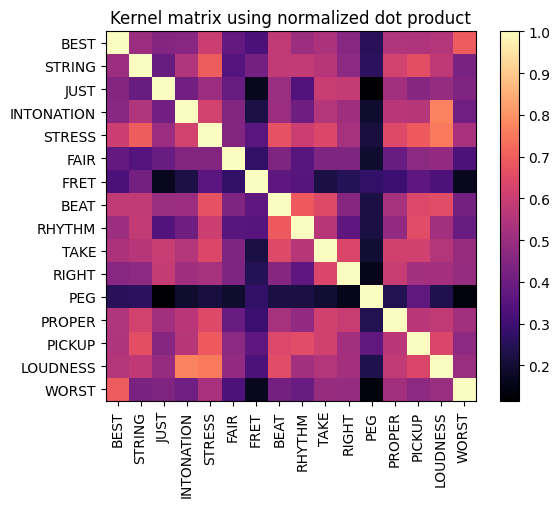

In [8]:
K1 = create_kernel_mat(words, normalized_dot_fn, model)
plot_kernel_mat(K1, words, title='Kernel matrix using normalized dot product')

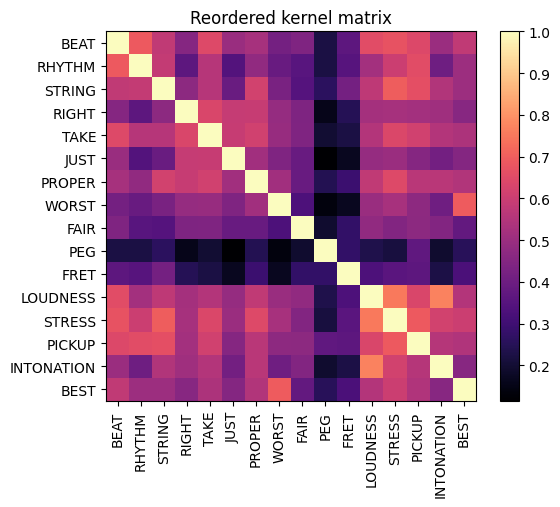

In [9]:
order = kmeans_order_from_K(K1, n_clusters=4)
K_sorted = apply_order(K1, order)
words_sorted = apply_order(words, order)

plot_kernel_mat(K_sorted, words_sorted, title='Reordered kernel matrix')

## Kernel function 2: RBF kernel

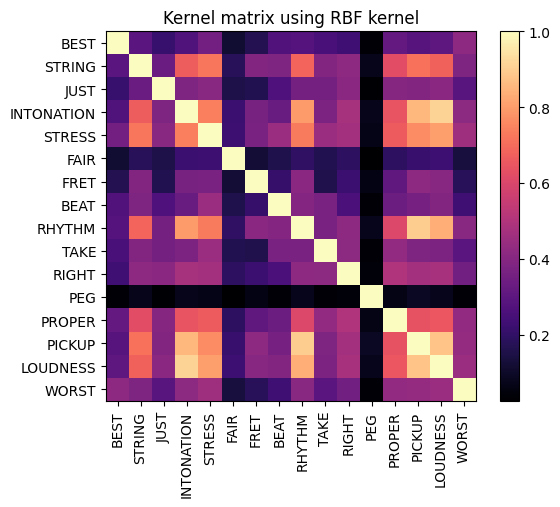

In [10]:
K2 = create_kernel_mat(words, rbf_kernel_fn, model, gamma=compute_gamma(words, model))
plot_kernel_mat(K2, words, title='Kernel matrix using RBF kernel')

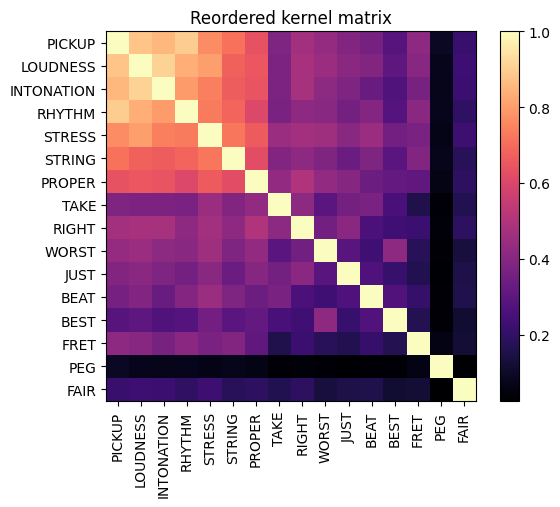

In [11]:
order = kmeans_order_from_K(K2, n_clusters=4)
K_sorted = apply_order(K2, order)
words_sorted = apply_order(words, order)

plot_kernel_mat(K_sorted, words_sorted, title='Reordered kernel matrix')

## Prepare data

In [12]:
# each entry in data contains:
# a [16, 300] tensor: 16 vectors
# a 16-dim vector of labels
# a list of 16 words
data = []

for game in games:
    if np.nan in game['words']:
        continue

    X = torch.tensor(  # 16 x 300
        np.stack([model[word] for word in game['words']]),
        dtype=torch.float32
    )
    y = torch.tensor(game['labels'], dtype=torch.long)  # (16,)
    data.append((X, y, game['words']))

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data,
                                         test_size=0.2,
                                         random_state=42)

## Build model
### Train a model with paramter as a (300, 300) matrix W s.t. the kernel is <W(x), W(y)>

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LinearKernel(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.layer = nn.Linear(in_features=d, out_features=d, bias=False)

    def forward(self, x):
        return self.layer(x)

kernel = LinearKernel(300).to(device)
kernel

LinearKernel(
  (layer): Linear(in_features=300, out_features=300, bias=False)
)

## Train & Test Loop

epoch 0  avg_loss=0.166
epoch 10  avg_loss=0.127
epoch 20  avg_loss=0.124
epoch 30  avg_loss=0.122
epoch 40  avg_loss=0.121
epoch 50  avg_loss=0.120


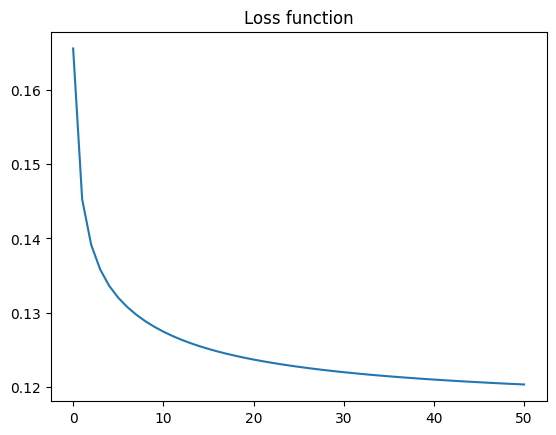

In [14]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(kernel.parameters(), lr=0.01)

epochs = 51
loss_list = []

for epoch in range(epochs):
    kernel.train()
    total_loss = 0

    for X_train, y_train, _ in data_train:
        X_train, y_train = X_train.to(device), y_train.to(device)

        Z = kernel(X_train)  # kernel calculates each row of X_train
        Z = F.normalize(Z, p=2, dim=1)  # normal each row of Z
        K = Z @ Z.T  # calculate the kernel matrix

        D = (y_train[:, None] == y_train[None, :]).float().to(Z.device)
        loss = ((K - D)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(data_train)
    loss_list.append(avg)
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"epoch {epoch}  avg_loss={avg:.3f}")

plt.plot(loss_list)
plt.title('Loss function')
plt.show()

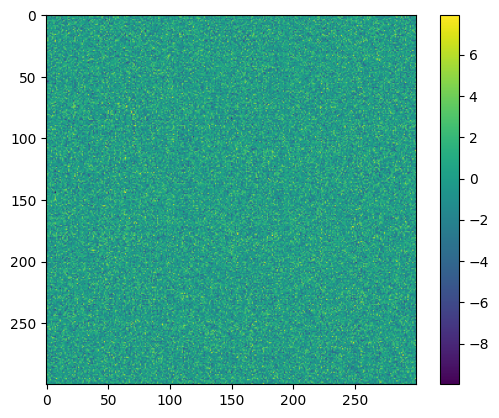

In [15]:
# plot the parameter matrix
plt.imshow(kernel.state_dict()['layer.weight'].cpu().numpy())
plt.colorbar()
plt.show()

## Evaluate the model

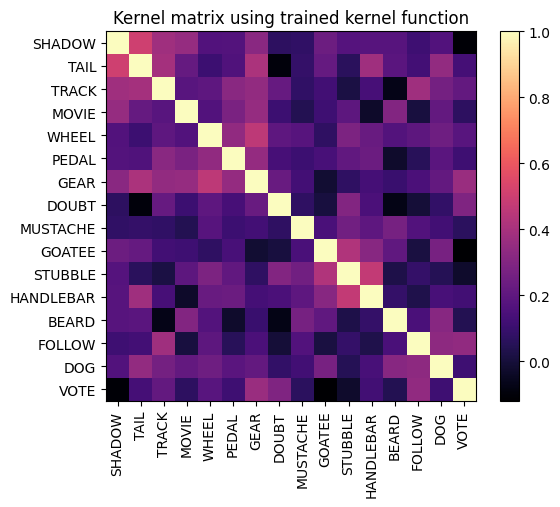

In [16]:
kernel.eval()
X0, y0, words_test = data_test[0]
X0 = X0.to(device)

with torch.inference_mode():
    Z0 = kernel(X0)
    Z0 = F.normalize(Z0, dim=1)
    K0 = (Z0 @ Z0.t()).cpu().numpy()

order = kmeans_order_from_K(K0, n_clusters=4)
K_sorted = apply_order(K0, order)
words_sorted = apply_order(words_test, order)

plot_kernel_mat(K_sorted, words_sorted, title='Kernel matrix using trained kernel function')

In [17]:
get_answer(words_test, y0)

['BEARD' 'GOATEE' 'MUSTACHE' 'STUBBLE']
['GEAR' 'HANDLEBAR' 'WHEEL' 'PEDAL']
['DOG' 'TRACK' 'TAIL' 'FOLLOW']
['SHADOW' 'VOTE' 'MOVIE' 'DOUBT']


## Evaluate on a customized example

In [23]:
test0 = ['red', 'blue', 'yellow', 'black',
        'train', 'flight', 'bus', 'underground',
        'math', 'physics', 'chemistry', 'humanities',
        'Oxford', 'Cambridge', 'UCL', 'Imperial']

shuffle(test0)
test0

['train',
 'math',
 'flight',
 'chemistry',
 'underground',
 'Cambridge',
 'humanities',
 'black',
 'Oxford',
 'physics',
 'Imperial',
 'yellow',
 'bus',
 'UCL',
 'blue',
 'red']

In [24]:
def evaluate(words, model, kernel, title='', **kwargs):
    """
    :param words: list of words
    :param model: dict mapping words to (300,) vectors
    :param kernel: kernel function, could be a PyTorch model (act as matrix multiplication) or a bivariate function
    :param title: title displayed in plotted graph
    :param kwargs: additional parameters
    :return: plot the reordered kernel matrix
    """

    X0 = torch.tensor(  # 16 x 300
        np.stack([model[word] for word in words]),
        dtype=torch.float32
    )

    if isinstance(kernel, nn.Module):
        kernel.eval()
        X0 = X0.to(device)
        with torch.inference_mode():
            Z0 = kernel(X0)
            Z0 = F.normalize(Z0, dim=1)
            K0 = (Z0 @ Z0.t()).cpu().numpy()

    else:
        K0 = create_kernel_mat(words, kernel, model, **kwargs)

    order = kmeans_order_from_K(K0, n_clusters=4)
    K_sorted = apply_order(K0, order)
    words_sorted = apply_order(test0, order)

    plot_kernel_mat(K_sorted, words_sorted, title=title)

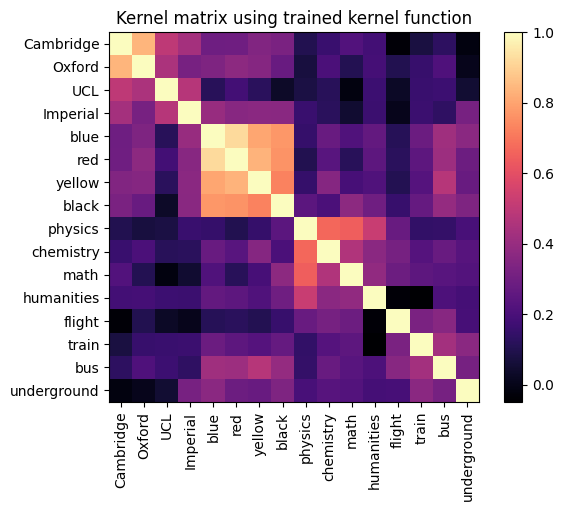

In [25]:
evaluate(test0, model, kernel, title='Kernel matrix using trained kernel function')

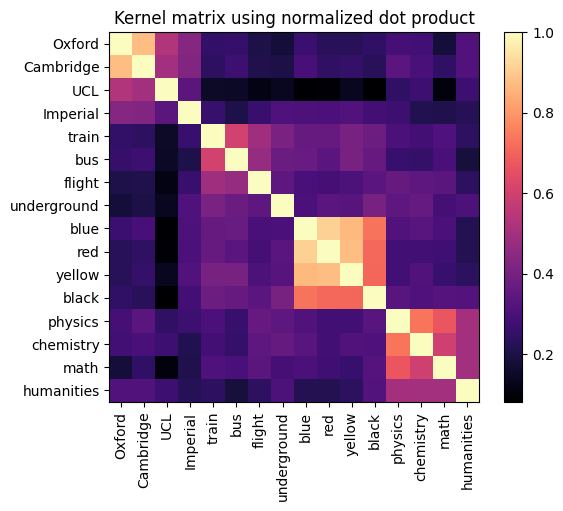

In [26]:
evaluate(test0, model, normalized_dot_fn, title='Kernel matrix using normalized dot product')

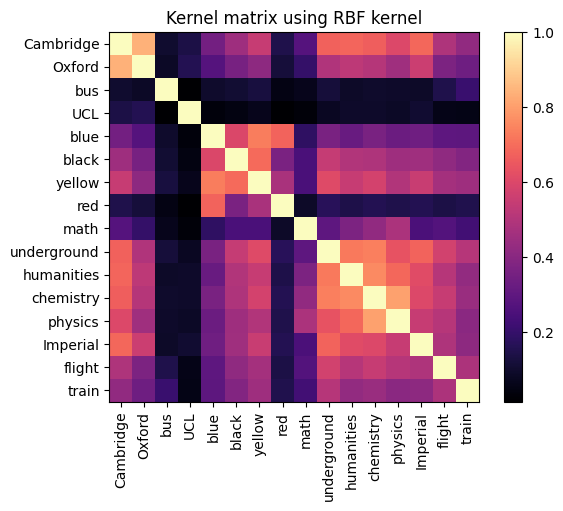

In [27]:
evaluate(test0, model, rbf_kernel_fn, gamma=compute_gamma(test0, model), title='Kernel matrix using RBF kernel')